In [1]:
import pandas as pd
import mplfinance as mpf


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

#Импортируем необходимые библиотеки

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
esa_df = pd.read_csv(r'''\Users\user13\Olga's Research\Bar Research\ver\es1.csv''')
esa_df['Dates'] = pd.to_datetime(esa_df['Dates'], format='%m/%d/%Y %H:%M')
esa_df.set_index('Dates', inplace=True)
#Загружаем ES1 Index (generic) с 08-01-2020 по наст вр

In [6]:
esa_df

,Open,Close,High,Low,Volume
Dates,,,,,
2020-01-08 22:00:00,3261.25,3262.25,3263.25,3260.00,3771
2020-01-08 22:10:00,3262.25,3264.25,3264.50,3261.75,1678
2020-01-08 22:20:00,3264.25,3264.00,3264.75,3263.25,1459
2020-01-08 22:30:00,3264.25,3261.25,3264.25,3259.00,3069
2020-01-08 22:40:00,3261.00,3261.75,3262.50,3260.50,1987
...,...,...,...,...,...
2020-07-23 06:30:00,3274.25,3274.50,3274.75,3273.00,1255
2020-07-23 06:40:00,3274.50,3281.00,3284.50,3274.25,9001
2020-07-23 06:50:00,3280.75,3280.75,3282.00,3280.00,2386


In [7]:
def add_closes(df: pd.DataFrame) -> pd.DataFrame:

    df['price_change'] = df['Close'] - df['Open']
    df['proj_close'] = 0.8 * (df['High'] - df['Open']) + df['Open']

    return df
#Функция добавляет колонки условий

In [8]:
esa_df = add_closes(esa_df)
esa_df.head()
# Из всех свечей с выбранным условием уберем те,  у которых price_change отриц, т е они идут вниз
# Применим функцию, берущую только те свечи где Цена закрытия больше proj_close

,Open,Close,High,Low,Volume,price_change,proj_close
Dates,,,,,,,
2020-01-08 22:00:00,3261.25,3262.25,3263.25,3260.00,3771,1.00,3262.85
2020-01-08 22:10:00,3262.25,3264.25,3264.50,3261.75,1678,2.00,3264.05
2020-01-08 22:20:00,3264.25,3264.00,3264.75,3263.25,1459,-0.25,3264.65
2020-01-08 22:30:00,3264.25,3261.25,3264.25,3259.00,3069,-3.00,3264.25
2020-01-08 22:40:00,3261.00,3261.75,3262.50,3260.50,1987,0.75,3262.20


In [9]:
def get_rising_candles(df: pd.DataFrame) -> pd.DataFrame:
    new_df = pd.DataFrame(columns=['group_no'])
    # Apply main filter Close price >= projected Close Price AND price change > 0
    tmp_df = df[(df['price_change'] > 0) & (df['Close'] >= df['proj_close'])]
    stop_iter = len(tmp_df)

    for i in range(stop_iter - 1):
        if ((tmp_df.iloc[i+1].name - pd.Timedelta('10 m') == tmp_df.iloc[i].name) and
            (tmp_df.iloc[i+1].Close > tmp_df.iloc[i].Close)):
            new_df = new_df.append(tmp_df.iloc[i])
            new_df = new_df.append(tmp_df.iloc[i+1])
        else:
            new_df.loc[new_df.group_no.isna(), 'group_no'] = i
    
    new_df.loc[new_df.group_no.isna(), 'group_no'] = stop_iter

    new_df.drop_duplicates(inplace=True)
    td = new_df.groupby('group_no')['group_no'].count().to_frame()
    dd = {i:r['group_no'] for i, r in td.iterrows()}
    new_df['group_q'] = new_df['group_no'].map(dd)
    return new_df

#Функция пропускает все данные через условия + где изменение цены больше 0,т е только положительные свечи
# Плюс дополнительное условие , показать свечи,каждое открытие последующих выше предыдущего 

In [10]:
sorted_esa_df = get_rising_candles(esa_df)
sorted_esa_df.head()

,group_no,Close,High,Low,Open,Volume,price_change,proj_close,group_q
2020-01-09 03:20:00,10,3261.75,3261.75,3261.00,3261.25,390.0,0.50,3261.65,3
2020-01-09 03:30:00,10,3263.00,3263.00,3261.75,3261.75,803.0,1.25,3262.75,3
2020-01-09 03:40:00,10,3263.50,3263.50,3262.75,3263.00,592.0,0.50,3263.40,3
2020-01-09 12:30:00,17,3271.50,3271.50,3269.75,3270.00,5224.0,1.50,3271.20,2
2020-01-09 12:40:00,17,3271.75,3271.75,3270.75,3271.50,3544.0,0.25,3271.70,2


In [11]:
sorted_esa_df
sorted_esa_df.head()
# Переприсваиваем новый датафрейм - получаем только положительные свечи с выбранным условием которые идут подряд

,group_no,Close,High,Low,Open,Volume,price_change,proj_close,group_q
2020-01-09 03:20:00,10,3261.75,3261.75,3261.00,3261.25,390.0,0.50,3261.65,3
2020-01-09 03:30:00,10,3263.00,3263.00,3261.75,3261.75,803.0,1.25,3262.75,3
2020-01-09 03:40:00,10,3263.50,3263.50,3262.75,3263.00,592.0,0.50,3263.40,3
2020-01-09 12:30:00,17,3271.50,3271.50,3269.75,3270.00,5224.0,1.50,3271.20,2
2020-01-09 12:40:00,17,3271.75,3271.75,3270.75,3271.50,3544.0,0.25,3271.70,2


In [12]:
# Calculate how many cases in here:

sorted_esa_df[['group_no', 'group_q']].drop_duplicates().groupby('group_q')['group_no'].count().to_frame()

,group_no
group_q,
2,379
3,54
4,7
5,2
7,1


In [13]:
len(sorted_esa_df.group_no.unique())

443

In [14]:
tmp_df = sorted_esa_df.loc['2020-07-01':'2020-07-02']

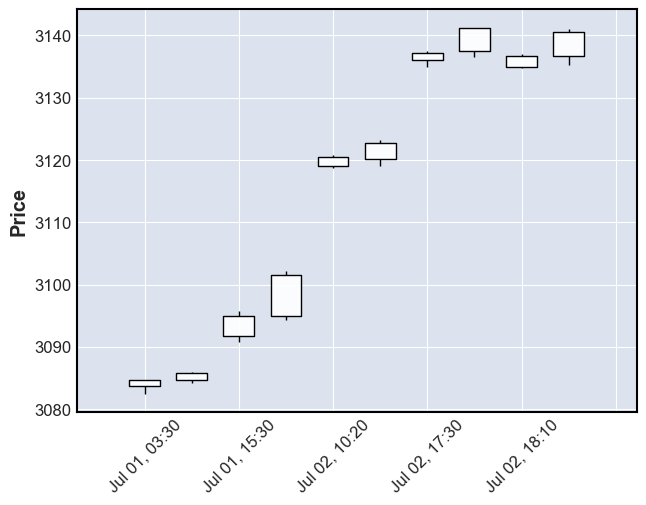

In [15]:
mpf.plot(tmp_df, type='candlestick')

In [16]:
# filter for you PLOTLY graph

fig = go.Figure(data=go.Candlestick(x=tmp_df.index,
                    open=tmp_df['Open'],
                    high=tmp_df['High'],
                    low=tmp_df['Low'],
                    close=tmp_df['Close']))
fig.update_layout(height=500)
fig.show()
